# Initialization

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# to prettify code run ceil and press then f5
#!pip install black[jupyter]==23.12.0 -q
# !black /content/drive/MyDrive/PROJECTS_COMPETITIONS/ConDT/ConDT_implementation_CORL_based.ipynb

All done! ✨ 🍰 ✨
1 file left unchanged.


In [ ]:
!pip install 'cython<3' -q # ==0.29.36
!pip install tqdm==4.64.0 -q
!pip install wandb==0.16.1 -q
!pip install pyrallis -q
!pip install pre-commit==3.3.3 -q
!pip install ruff==0.0.278 -q
!pip install --upgrade ipykernel -q

In [ ]:
# mujoco installation for colab
!wget https://roboti.us/download/mujoco200_linux.zip
!wget https://roboti.us/file/mjkey.txt


!mkdir /root/.mujoco
!unzip mujoco200_linux.zip -d /root/.mujoco/
!cp -r /root/.mujoco/mujoco200_linux /root/.mujoco/mujoco200
!mv mjkey.txt /root/.mujoco/
!cp -r /root/.mujoco/mujoco200/bin/* /usr/lib/

In [ ]:
!apt-get install -q -y \
   libgl1-mesa-dev \
   libgl1-mesa-glx \
   libglew-dev \
   libosmesa6-dev \
   software-properties-common

!apt-get install -y patchelf -q
!pip install free-mujoco-py -q

In [ ]:
%env LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/root/.mujoco/mujoco200/bin
import mujoco_py

In [ ]:
!pip install -q git+https://github.com/tinkoff-ai/d4rl@master#egg=d4rl

In [ ]:
import os
import gc
import random
import uuid
from collections import defaultdict
from dataclasses import asdict, dataclass
from typing import Any, DefaultDict, Dict, List, Optional, Tuple, Union

import d4rl  # noqa
import gym
import numpy as np
import pyrallis
import torch
import torch.nn as nn
import wandb
from torch.nn import functional as F
from torch.utils.data import DataLoader, IterableDataset
from tqdm.auto import tqdm, trange  # noqa

# Generla Utills

In [ ]:
@dataclass
class TrainConfig:
    # model params
    embedding_dim: int = 128
    num_layers: int = 3
    num_heads: int = 1
    seq_len: int = 20
    episode_len: int = 1000
    attention_dropout: float = 0.1
    residual_dropout: float = 0.1
    embedding_dropout: float = 0.1
    max_action: float = 1.0
    # ConDT params
    latent_state_action_dim: int = 64
    n_bins: int = 10
    # pretraning params
    smoothing_factor: float = 0.07
    pretrain_steps: int = 2000
    pretrain_eval_episodes: int = 10
    pretrain_eval_every: int = 500
    temperature: float = 0.1
    pretrain_batch_size: int = 64
    pretrain_learning_rate: float = 0.006
    pretrain_weight_decay: float = 0.0001
    pretrain_eval_batch_size: int = 1024
    # training params
    env_name: str = "hammer-expert-v1"
    learning_rate: float = 0.0008
    betas: Tuple[float, float] = (0.9, 0.999)
    weight_decay: float = 0.0001
    clip_grad: Optional[float] = 0.25
    batch_size: int = 4096
    update_steps: int = 100000
    warmup_steps: int = 10000
    reward_scale: float = 0.001
    num_workers: int = 4
    # evaluation params
    target_returns: Tuple[float, ...] = (12800.0,)  #
    eval_episodes: int = 100
    eval_every: int = 10000
    # general params
    checkpoints_path: Optional[str] = None
    deterministic_torch: bool = False
    train_seed: int = 9
    eval_seed: int = 24
    device: str = "cuda"
    # wandb params
    project: str = "ConDT"
    group: str = env_name
    name: str = "DT"

    def __post_init__(self):
        self.name = f"{self.name}-{self.env_name}-{str(uuid.uuid4())[:8]}"
        if self.checkpoints_path is not None:
            self.checkpoints_path = os.path.join(self.checkpoints_path, self.name)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  """Restore raw_input, getpass"""


In [ ]:
# general utils
def set_seed(
    seed: int, env: Optional[gym.Env] = None, deterministic_torch: bool = False
):
    if env is not None:
        env.seed(seed)
        env.action_space.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.use_deterministic_algorithms(deterministic_torch)


def clear_cache():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()


def wandb_init(config: dict, resume: bool = False) -> None:
    wandb.init(
        config=config,
        project=config["project"],
        # group=config["group"],
        name=config["name"],
        id=str(uuid.uuid4()),
        resume=resume,
    )
    wandb.run.save()


def wrap_env(
    env: gym.Env,
    state_mean: Union[np.ndarray, float] = 0.0,
    state_std: Union[np.ndarray, float] = 1.0,
    reward_scale: float = 1.0,
) -> gym.Env:
    def normalize_state(state):
        return (state - state_mean) / state_std

    def scale_reward(reward):
        return reward_scale * reward

    env = gym.wrappers.TransformObservation(env, normalize_state)
    if reward_scale != 1.0:
        env = gym.wrappers.TransformReward(env, scale_reward)
    return env

# DT Utils

In [ ]:
def pad_along_axis(
    arr: np.ndarray, pad_to: int, axis: int = 0, fill_value: float = 0.0
) -> np.ndarray:
    pad_size = pad_to - arr.shape[axis]
    if pad_size <= 0:
        return arr

    npad = [(0, 0)] * arr.ndim
    npad[axis] = (0, pad_size)
    return np.pad(arr, pad_width=npad, mode="constant", constant_values=fill_value)


def discounted_cumsum(x: np.ndarray, gamma: float) -> np.ndarray:
    cumsum = np.zeros_like(x)
    cumsum[-1] = x[-1]
    for t in reversed(range(x.shape[0] - 1)):
        cumsum[t] = x[t] + gamma * cumsum[t + 1]
    return cumsum


def load_d4rl_trajectories(
    env_name: str, gamma: float = 1.0
) -> Tuple[List[DefaultDict[str, np.ndarray]], Dict[str, Any]]:
    dataset = gym.make(env_name).get_dataset()
    traj, traj_len = [], []

    data_ = defaultdict(list)
    for i in trange(dataset["rewards"].shape[0], desc="Processing trajectories"):
        data_["observations"].append(dataset["observations"][i])
        data_["actions"].append(dataset["actions"][i])
        data_["rewards"].append(dataset["rewards"][i])

        if dataset["terminals"][i] or dataset["timeouts"][i]:
            episode_data = {k: np.array(v, dtype=np.float32) for k, v in data_.items()}
            # return-to-go if gamma=1.0, just discounted returns else
            episode_data["returns"] = discounted_cumsum(
                episode_data["rewards"], gamma=gamma
            )
            traj.append(episode_data)
            traj_len.append(episode_data["actions"].shape[0])
            # reset trajectory buffer
            data_ = defaultdict(list)

    # needed for normalization, weighted sampling, other stats can be added also
    info = {
        "obs_mean": dataset["observations"].mean(0, keepdims=True),
        "obs_std": dataset["observations"].std(0, keepdims=True) + 1e-6,
        "traj_lens": np.array(traj_len),
    }
    return traj, info


class SequenceDataset(IterableDataset):
    def __init__(self, env_name: str, seq_len: int = 10, reward_scale: float = 1.0):
        self.dataset, info = load_d4rl_trajectories(env_name, gamma=1.0)
        self.reward_scale = reward_scale
        self.seq_len = seq_len

        self.state_mean = info["obs_mean"]
        self.state_std = info["obs_std"]
        # https://github.com/kzl/decision-transformer/blob/e2d82e68f330c00f763507b3b01d774740bee53f/gym/experiment.py#L116 # noqa
        self.sample_prob = info["traj_lens"] / info["traj_lens"].sum()

    def __prepare_sample(self, traj_idx, start_idx):
        traj = self.dataset[traj_idx]
        # https://github.com/kzl/decision-transformer/blob/e2d82e68f330c00f763507b3b01d774740bee53f/gym/experiment.py#L128 # noqa
        states = traj["observations"][start_idx : start_idx + self.seq_len]
        actions = traj["actions"][start_idx : start_idx + self.seq_len]
        returns = traj["returns"][start_idx : start_idx + self.seq_len]
        time_steps = np.arange(start_idx, start_idx + self.seq_len)

        states = (states - self.state_mean) / self.state_std
        returns = returns * self.reward_scale
        # pad up to seq_len if needed
        mask = np.hstack(
            [np.ones(states.shape[0]), np.zeros(self.seq_len - states.shape[0])]
        )
        if states.shape[0] < self.seq_len:
            states = pad_along_axis(states, pad_to=self.seq_len)
            actions = pad_along_axis(actions, pad_to=self.seq_len)
            returns = pad_along_axis(returns, pad_to=self.seq_len)

        return states, actions, returns, time_steps, mask

    def __iter__(self):
        while True:
            traj_idx = np.random.choice(len(self.dataset), p=self.sample_prob)
            start_idx = random.randint(
                0, self.dataset[traj_idx]["rewards"].shape[0] - 1
            )
            yield self.__prepare_sample(traj_idx, start_idx)

# ConDT implementation

## Embeddings model

In [ ]:


class Embeddings(nn.Module):
    def __init__(self, state_dim, act_dim, h_dim):
        super().__init__()
        self.embed_rtg = nn.Sequential(  # nonlinear layer as mentioned in paper
            nn.Linear(1, 2 * h_dim),
            nn.ReLU(),  # nn.GELU() \
            nn.Linear(2 * h_dim, h_dim),
        )

        self.embed_state = torch.nn.Linear(state_dim, h_dim)
        self.embed_action = torch.nn.Linear(act_dim, h_dim)
        self.apply(self._init_weights)

    def forward(self, rtg, states, actions):
        latent_rtg = self.embed_rtg(rtg.unsqueeze(-1))
        latent_states = self.embed_state(states) * latent_rtg
        latent_actions = self.embed_action(actions) * latent_rtg
        return latent_states, latent_actions

    @staticmethod
    def _init_weights(module: nn.Module):
        if isinstance(module, Embeddings):
            pass
        elif isinstance(module, (nn.Linear, nn.Embedding)):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if isinstance(module, nn.Linear) and module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.zeros_(module.bias)
            torch.nn.init.ones_(module.weight)


class DTsa(nn.Module):
    def __init__(self, latent_state_action_dim, h_dim):
        super().__init__()
        self.embed_latent_state_action = torch.nn.Linear(
            2 * h_dim, latent_state_action_dim
        )

    def forward(self, latent_state, latent_action):
        state_action = torch.cat([latent_state, latent_action], dim=-1)
        latent_state_action = self.embed_latent_state_action(state_action)

        return latent_state_action

## ConDT

In [ ]:
# inspiration:
# 1. https://github.com/kzl/decision-transformer/blob/master/gym/decision_transformer/models/decision_transformer.py  # noqa
# 2. https://github.com/karpathy/minGPT


class TransformerBlock(nn.Module):
    def __init__(
        self,
        seq_len: int,
        embedding_dim: int,
        num_heads: int,
        attention_dropout: float,
        residual_dropout: float,
    ):
        super().__init__()
        self.norm1 = nn.LayerNorm(embedding_dim)
        self.norm2 = nn.LayerNorm(embedding_dim)
        self.drop = nn.Dropout(residual_dropout)

        self.attention = nn.MultiheadAttention(
            embedding_dim, num_heads, attention_dropout, batch_first=True
        )
        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim, 4 * embedding_dim),
            nn.GELU(),
            nn.Linear(4 * embedding_dim, embedding_dim),
            nn.Dropout(residual_dropout),
        )
        # True value indicates that the corresponding position is not allowed to attend
        self.register_buffer(
            "causal_mask", ~torch.tril(torch.ones(seq_len, seq_len)).to(bool)
        )
        self.seq_len = seq_len

    # [batch_size, seq_len, emb_dim] -> [batch_size, seq_len, emb_dim]
    def forward(
        self, x: torch.Tensor, padding_mask: Optional[torch.Tensor] = None
    ) -> torch.Tensor:
        causal_mask = self.causal_mask[: x.shape[1], : x.shape[1]]

        norm_x = self.norm1(x)
        attention_out = self.attention(
            query=norm_x,
            key=norm_x,
            value=norm_x,
            attn_mask=causal_mask,
            key_padding_mask=padding_mask,
            need_weights=False,
        )[0]
        # by default pytorch attention does not use dropout
        # after final attention weights projection, while minGPT does:
        # https://github.com/karpathy/minGPT/blob/7218bcfa527c65f164de791099de715b81a95106/mingpt/model.py#L70 # noqa
        x = x + self.drop(attention_out)
        x = x + self.mlp(self.norm2(x))
        return x


class ContrastiveDecisionTransformer(nn.Module):
    def __init__(
        self,
        embedder: Embeddings,
        state_dim: int,
        action_dim: int,
        seq_len: int = 10,
        episode_len: int = 1000,
        embedding_dim: int = 128,
        num_layers: int = 4,
        num_heads: int = 8,
        attention_dropout: float = 0.0,
        residual_dropout: float = 0.0,
        embedding_dropout: float = 0.0,
        max_action: float = 1.0,
    ):
        super().__init__()
        self.emb_drop = nn.Dropout(embedding_dropout)
        self.emb_norm = nn.LayerNorm(embedding_dim)

        self.out_norm = nn.LayerNorm(embedding_dim)
        # additional seq_len embeddings for padding timesteps
        self.timestep_emb = nn.Embedding(episode_len + seq_len, embedding_dim)

        self.blocks = nn.ModuleList(
            [
                TransformerBlock(
                    seq_len=3 * seq_len,
                    embedding_dim=embedding_dim,
                    num_heads=num_heads,
                    attention_dropout=attention_dropout,
                    residual_dropout=residual_dropout,
                )
                for _ in range(num_layers)
            ]
        )
        self.action_head = nn.Sequential(
            nn.Linear(embedding_dim, action_dim), nn.Tanh()
        )
        self.seq_len = seq_len
        self.embedding_dim = embedding_dim
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.episode_len = episode_len
        self.max_action = max_action

        self.apply(self._init_weights)

        self.state_emb = embedder.embed_state
        self.action_emb = embedder.embed_action
        self.return_emb = embedder.embed_rtg

    @staticmethod
    def _init_weights(module: nn.Module):
        if isinstance(module, Embeddings):
            pass
        elif isinstance(module, (nn.Linear, nn.Embedding)):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if isinstance(module, nn.Linear) and module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.zeros_(module.bias)
            torch.nn.init.ones_(module.weight)

    def forward(
        self,
        states: torch.Tensor,  # [batch_size, seq_len, state_dim]
        actions: torch.Tensor,  # [batch_size, seq_len, action_dim]
        returns_to_go: torch.Tensor,  # [batch_size, seq_len]
        time_steps: torch.Tensor,  # [batch_size, seq_len]
        padding_mask: Optional[torch.Tensor] = None,  # [batch_size, seq_len]
    ) -> torch.FloatTensor:
        batch_size, seq_len = states.shape[0], states.shape[1]
        # [batch_size, seq_len, emb_dim]
        time_emb = self.timestep_emb(time_steps)

        returns_emb = self.return_emb(returns_to_go.unsqueeze(-1))
        state_emb = self.state_emb(states) * returns_emb + time_emb
        act_emb = self.action_emb(actions) * returns_emb + time_emb

        # [batch_size, seq_len * 3, emb_dim], (r_0, s_0, a_0, r_1, s_1, a_1, ...)
        sequence = (
            torch.stack([state_emb, act_emb], dim=1)
            .permute(0, 2, 1, 3)
            .reshape(batch_size, 2 * seq_len, self.embedding_dim)
        )
        if padding_mask is not None:
            # [batch_size, seq_len * 2], stack mask identically to fit the sequence
            padding_mask = (
                torch.stack([padding_mask, padding_mask], dim=1)
                .permute(0, 2, 1)
                .reshape(batch_size, 2 * seq_len)
            )
        # LayerNorm and Dropout (!!!) as in original implementation,
        # while minGPT & huggingface uses only embedding dropout
        out = self.emb_norm(sequence)
        out = self.emb_drop(out)

        for block in self.blocks:
            out = block(out, padding_mask=padding_mask)

        out = self.out_norm(out)
        out = out.reshape(batch_size, seq_len, 2, self.embedding_dim).permute(
            0, 2, 1, 3
        )
        action_preds = self.action_head(out[:, 0])

        # [batch_size, seq_len, action_dim]
        # predict actions only from state embeddings
        return action_preds

## Eval Func

In [ ]:
# Training and evaluation logic
@torch.no_grad()
def eval_rollout(
    model: ContrastiveDecisionTransformer,
    env: gym.Env,
    target_return: float,
    device: str = "cpu",
) -> Tuple[float, float]:
    states = torch.zeros(
        1, model.episode_len + 1, model.state_dim, dtype=torch.float, device=device
    )
    actions = torch.zeros(
        1, model.episode_len, model.action_dim, dtype=torch.float, device=device
    )
    returns = torch.zeros(1, model.episode_len + 1, dtype=torch.float, device=device)

    time_steps = torch.arange(model.episode_len, dtype=torch.long, device=device)
    time_steps = time_steps.view(1, -1)

    states[:, 0] = torch.as_tensor(env.reset(), device=device)
    returns[:, 0] = torch.as_tensor(target_return, device=device)

    # cannot step higher than model episode len, as timestep embeddings will crash
    episode_return, episode_len = 0.0, 0.0
    for step in range(model.episode_len):
        # first select history up to step, then select last seq_len states,
        # step + 1 as : operator is not inclusive, last action is dummy with zeros
        # (as model will predict last, actual last values are not important)
        predicted_actions = model(  # fix this noqa!!!
            states[:, : step + 1][:, -model.seq_len :],
            actions[:, : step + 1][:, -model.seq_len :],
            returns[:, : step + 1][:, -model.seq_len :],
            time_steps[:, : step + 1][:, -model.seq_len :],
        )
        predicted_action = predicted_actions[0, -1].cpu().numpy()
        next_state, reward, done, info = env.step(predicted_action)
        # at step t, we predict a_t, get s_{t + 1}, r_{t + 1}
        actions[:, step] = torch.as_tensor(predicted_action)
        states[:, step + 1] = torch.as_tensor(next_state)
        returns[:, step + 1] = torch.as_tensor(returns[:, step] - reward)

        episode_return += reward
        episode_len += 1

        if done:
            break

    return episode_return, episode_len

## Bined Dataset

In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt


class BinarizedDataset(IterableDataset):
    def __init__(
        self, dataset: SequenceDataset, n_bins: int = 10, smoothing_factor: float = 0.05
    ):
        self.n_bins = n_bins
        self.rsa = []  # array of tuples: return to-go, state, action

        state_std = dataset.state_std
        state_mean = dataset.state_mean
        reward_scale = dataset.reward_scale

        for traj in tqdm(dataset.dataset):
            states = traj["observations"]
            actions = traj["actions"]
            returns_to_go = traj["returns"]

            states = (states - state_mean) / state_std
            returns_to_go = returns_to_go * reward_scale  # returns_to_go

            traj_rsa = np.array(list(zip(returns_to_go, states, actions)))
            self.rsa.append(traj_rsa)

        # check atari colab for more efficient realization
        self.rsa = np.concatenate(self.rsa, axis=0)
        sorted_indices = np.argsort(self.rsa[:, 0])
        self.rsa = self.rsa[sorted_indices]  # np array sortet by reward to-go  it's inefficient but can afford now



        self.bins, self.bin_edges = self.bin_indices()

        self.bins_probs = np.array(
            [el[1] - el[0] + 1 if el[0] is not None else 0 for el in self.bins]
        )  # number of elements per bin
        self.bins_probs = self.bins_probs / self.bins_probs.sum()
        # Laplacian smoothing: make distribution more unoform
        self.bins_probs = (self.bins_probs + smoothing_factor) / (
            np.sum(self.bins_probs) + len(self.bins_probs) * smoothing_factor
        )

    def bin_indices(self):
        rtg_min, rtg_max = self.rsa[0][0], self.rsa[-1][0]  # for sorted array

        bins = np.linspace(
            rtg_min, rtg_max, self.n_bins + 1
        )  # split on n_bins equal chunks by rtg as mentioned in paper
        digitized = np.digitize(self.rsa[:, 0], bins + 1)

        indices = [
            (np.min(np.where(digitized == i)), np.max(np.where(digitized == i)))
            if i in digitized
            else (None, None)
            for i in range(1, self.n_bins + 1)
        ]
        return indices, bins

    def __iter__(
        self,
    ):  # sampling bin number then sampling anchor and posirive from bin
        while True:
            bin_idx = np.random.choice(np.arange(self.n_bins), p=self.bins_probs)
            l, r = self.bins[bin_idx]

            anchor_idx, pos_idx = random.randint(l, r), random.randint(l, r)
            while pos_idx == anchor_idx:  # if pos_idx and anchor_idx same
                pos_idx = random.randint(l, r)

            anchor = self.rsa[anchor_idx]
            pos = self.rsa[pos_idx]

            rtg = torch.tensor([anchor[0], pos[0]], dtype=torch.float32)
            states = torch.from_numpy(np.stack([anchor[1], pos[1]]))
            actions = torch.from_numpy(np.stack([anchor[2], pos[2]]))

            yield rtg, states, actions, bin_idx

## SimRCLRL

In [ ]:
def SimRCLRL(latent_state_action, t):  # (B, 2, latent_sa_dim)
    anc = latent_state_action[:, 0]
    pos = latent_state_action[:, 1]

    anc_pos_sim = F.cosine_similarity(anc, pos, dim=-1)  # anchor - positive sim
    mask = torch.eye(
        anc.shape[0], dtype=torch.bool, device=anc_pos_sim.device
    )  # mask diagonal

    pairvise_sim_anc_pos = torch.exp((
        F.cosine_similarity(anc[None, :, :], pos[:, None, :], dim=-1) / t)
    )  # anchor - negative sim
    pairvise_sim_anc_anc = torch.exp((
        F.cosine_similarity(anc[None, :, :], anc[:, None, :], dim=-1)/ t)
    )  # pos - negative sim

    pairvise_sim_anc_pos.masked_fill_(mask, 0) # or 0
    pairvise_sim_anc_anc.masked_fill_(mask, 0)

    loss = (
        -anc_pos_sim / t
        + (pairvise_sim_anc_pos + pairvise_sim_anc_anc).sum(axis=1).log()
    ).mean()  # in paper - .sum() ??
    return loss

In [ ]:
def mean_cossim(latent_state_action):  # (B, 2, latent_sa_dim)
    anc = latent_state_action[:, 0]
    pos = latent_state_action[:, 1]

    mean_pos_sim = F.cosine_similarity(anc, pos, dim=-1).mean()
    mask = torch.eye(anc.shape[0], dtype=torch.bool, device=mean_pos_sim.device)

    pairvise_sim_anc_pos = F.cosine_similarity(anc[None, :, :], pos[:, None, :], dim=-1)
    pairvise_sim_anc_anc = F.cosine_similarity(anc[None, :, :], anc[:, None, :], dim=-1)

    pairvise_sim_anc_pos.masked_fill_(mask, 0)
    pairvise_sim_anc_anc.masked_fill_(mask, 0)

    mean_neg_sim = (pairvise_sim_anc_pos + pairvise_sim_anc_anc).mean() / 2
    return mean_pos_sim, mean_neg_sim

# Traning

In [ ]:
clear_cache()

In [ ]:
import yaml

# # checkpoints_path = '/content/drive/MyDrive/PROJECTS_COMPETITIONS/ConDT/runs/DT-hammer-expert-v1-ea605b16'
load_from_checkpoint = False

if load_from_checkpoint and checkpoints_path is not None:
    with open(f"{checkpoints_path}/config.yaml", "r") as file:
        data = yaml.safe_load(file)
    config = TrainConfig(**data)
else:
    config = TrainConfig(
        update_steps=50000, eval_every=2000, eval_episodes=100, n_bins=30
    )
    config.checkpoints_path = (
        f"/content/drive/MyDrive/PROJECTS_COMPETITIONS/ConDT/runs/{config.name}"
    )

## Pretraning

In [ ]:
set_seed(config.train_seed, deterministic_torch=config.deterministic_torch)

wandb_init(asdict(config))

dataset = SequenceDataset(
    config.env_name, seq_len=config.seq_len, reward_scale=config.reward_scale
)
trainloader = DataLoader(
    dataset,
    batch_size=config.batch_size,
    pin_memory=True,
    num_workers=config.num_workers,
)
# evaluation environment with state & reward preprocessing (as in dataset above)
eval_env = wrap_env(
    env=gym.make(config.env_name),
    state_mean=dataset.state_mean,
    state_std=dataset.state_std,
    reward_scale=config.reward_scale,
)
# model & optimizer & scheduler setup
config.state_dim = eval_env.observation_space.shape[0]
config.action_dim = eval_env.action_space.shape[0]
config.n_bins = 10


In [ ]:

pretrain_dataset = BinarizedDataset(
    dataset, n_bins=config.n_bins, smoothing_factor=config.smoothing_factor
)

pretrainloader = DataLoader(
    pretrain_dataset,
    batch_size=config.pretrain_batch_size,
    pin_memory=True,
    num_workers=config.num_workers,
)

pretrain_eval_loader = DataLoader(
    pretrain_dataset,
    batch_size=config.pretrain_eval_batch_size,
    pin_memory=True,
    num_workers=config.num_workers,
)

embedder = Embeddings(config.state_dim, config.action_dim, config.embedding_dim).to(
    config.device
)
latent_embedder = DTsa(config.latent_state_action_dim, config.embedding_dim).to(
    config.device
)

modules = torch.nn.ModuleList([embedder, latent_embedder])
ptertain_optim = torch.optim.AdamW(
    modules.parameters(),
    lr=config.pretrain_learning_rate,
    weight_decay=config.pretrain_weight_decay,
)  # =wt_decay

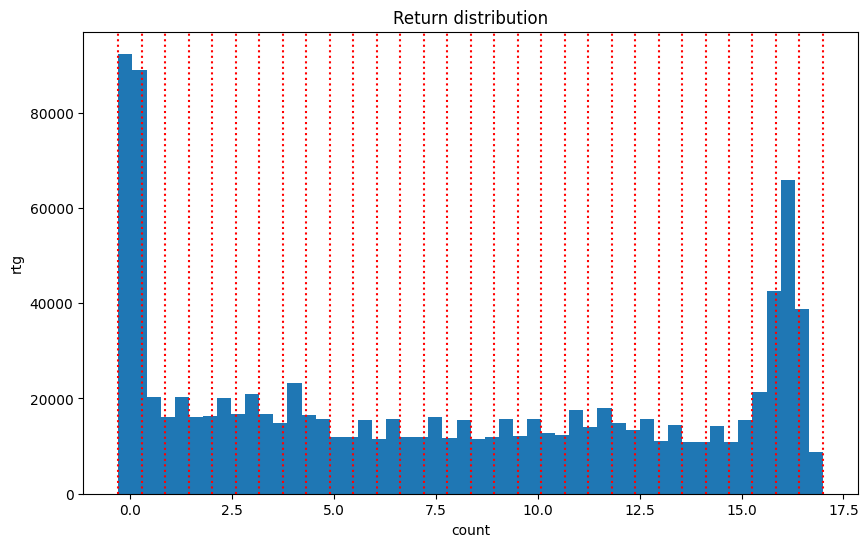

In [ ]:
import matplotlib.pyplot as plt

# there is a question - how to saple data from pretraning: uniform or proportionally

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(pretrain_dataset.rsa[:, 0], bins=50)
for xc in pretrain_dataset.bin_edges:
    ax.axvline(x=xc, color="red", ls=":")  # bins vizualization

ax.set_xlabel("count")
ax.set_ylabel("rtg")
ax.set_title("Return distribution")  # rtg i mean of course

plt.show()

In [ ]:
pretrainloader_iter = iter(pretrainloader)
pretrainloader_iter_eval = iter(pretrain_eval_loader)

for step in trange(config.pretrain_steps, desc="Pretraining"):
    batch = next(pretrainloader_iter)

    returns, states, actions = [b.to(config.device) for b in batch]

    latent_states, latent_actions = embedder(returns, states, actions)
    latent_state_actions = latent_embedder(latent_states, latent_actions)

    loss = SimRCLRL(latent_state_actions, t=config.temperature)
    pos_cossim, neg_cossim = mean_cossim(latent_state_actions)

    ptertain_optim.zero_grad()
    loss.backward()
    ptertain_optim.step()

    wandb.log(
        {
            "pretrain_loss": loss.item(),
            "Positive_cossim_pretrain": pos_cossim.item(),
            "Negative_cossim_pretrain": neg_cossim.item(),
            "pretrain_step": step,
        },
    )
    # validation in the env for the actual online performance
    if step % config.pretrain_eval_every == 0:
        embedder.eval()
        latent_embedder.eval()

        # for _ in trange(pretrain_eval_episodes, desc="Evaluation", leave=False):
        batch = next(pretrainloader_iter_eval)  # just sampling
        returns, states, actions = [b.to(config.device) for b in batch]
        latent_states, latent_actions = embedder(returns, states, actions)
        latent_state_actions = latent_embedder(latent_states, latent_actions)
        pos_cossim, neg_cossim = mean_cossim(latent_state_actions)

        wandb.log(
            {
                f"Positive_cossim_pretrain_eval": pos_cossim.item(),
                f"Negative_cossim_pretrain_eval": neg_cossim.item(),
            },
        )

        embedder.train()
        latent_embedder.train()

## Traning

In [ ]:
model = ContrastiveDecisionTransformer(
    embedder=embedder,
    state_dim=config.state_dim,
    action_dim=config.action_dim,
    embedding_dim=config.embedding_dim,
    seq_len=config.seq_len,
    episode_len=config.episode_len,
    num_layers=config.num_layers,
    num_heads=config.num_heads,
    attention_dropout=config.attention_dropout,
    residual_dropout=config.residual_dropout,
    embedding_dropout=config.embedding_dropout,
    max_action=config.max_action,
).to(config.device)


optim = torch.optim.AdamW(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay,
    betas=config.betas,
)

scheduler = torch.optim.lr_scheduler.LambdaLR(
    optim,
    lambda steps: min((steps + 1) / config.warmup_steps, 1),
)

# save config to the checkpoint
if config.checkpoints_path is not None:
    print(f"Checkpoints path: {config.checkpoints_path}")
    os.makedirs(config.checkpoints_path, exist_ok=True)
    with open(os.path.join(config.checkpoints_path, "config.yaml"), "w") as f:
        pyrallis.dump(config, f)
print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")

Checkpoints path: /content/drive/MyDrive/PROJECTS_COMPETITIONS/ConDT/runs/DT-hammer-expert-v1-fd98ead5
Total parameters: 772122


In [ ]:
trainloader_iter = iter(trainloader)
for step in trange(config.update_steps, desc="Training"):
    batch = next(trainloader_iter)
    states, actions, returns, time_steps, mask = [b.to(config.device) for b in batch]
    # True value indicates that the corresponding key value will be ignored
    padding_mask = ~mask.to(torch.bool)
    predicted_actions = model(
        states=states,
        actions=actions,
        returns_to_go=returns,
        time_steps=time_steps,
        padding_mask=padding_mask,
    )
    loss = F.mse_loss(predicted_actions, actions.detach(), reduction="none")
    # [batch_size, seq_len, action_dim] * [batch_size, seq_len, 1]
    loss = (loss * mask.unsqueeze(-1)).mean()
    optim.zero_grad()
    loss.backward()
    if config.clip_grad is not None:
        torch.nn.utils.clip_grad_norm_(model.parameters(), config.clip_grad)
    optim.step()
    scheduler.step()
    wandb.log(
        {
            "train_loss": loss.item(),
            "learning_rate": scheduler.get_last_lr()[0],
            "train_step": step,
        },
    )
    # validation in the env for the actual online performance
    if step % config.eval_every == 0 or step == config.update_steps - 1:
        model.eval()
        for target_return in config.target_returns:
            eval_env.seed(config.eval_seed)
            eval_returns = []
            for _ in trange(config.eval_episodes, desc="Evaluation", leave=False):
                eval_return, eval_len = eval_rollout(
                    model=model,
                    env=eval_env,
                    target_return=target_return * config.reward_scale,
                    device=config.device,
                )
                # unscale for logging & correct normalized score computation
                eval_returns.append(eval_return / config.reward_scale)
            normalized_scores = (
                eval_env.get_normalized_score(np.array(eval_returns)) * 100
            )
            wandb.log(
                {
                    f"eval/{target_return}_return_mean": np.mean(eval_returns),
                    f"eval/{target_return}_return_std": np.std(eval_returns),
                    f"eval/{target_return}_normalized_score_mean": np.mean(
                        normalized_scores
                    ),
                    f"eval/{target_return}_normalized_score_std": np.std(
                        normalized_scores
                    ),
                    "train_step": step,
                },
            )
            if config.checkpoints_path is not None:
                checkpoint = {
                    "model_state": model.state_dict(),
                    "optimizer_state_dict": optim.state_dict(),
                    "embedder_state": embedder.state_dict(),
                    "latent_embedder": latent_embedder.state_dict(),
                    "state_mean": dataset.state_mean,
                    "state_std": dataset.state_std,
                    "step": step,
                }
            torch.save(
                checkpoint, os.path.join(config.checkpoints_path, "dt_checkpoint.pt")
            )
        model.train()

Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
if config.checkpoints_path is not None:
    checkpoint = {
        "model_state": model.state_dict(),
        "optimizer_state_dict": optim.state_dict(),
        "embedder_state": embedder.state_dict(),
        "latent_embedder": latent_embedder.state_dict(),
        "state_mean": dataset.state_mean,
        "state_std": dataset.state_std,
        "traning_config": config,
        "step": step,
    }
    torch.save(checkpoint, os.path.join(config.checkpoints_path, "dt_checkpoint.pt"))

In [ ]:
model.eval()
for target_return in config.target_returns:
    eval_env.seed(config.eval_seed)
    eval_returns = []
    for _ in trange(config.eval_episodes, desc="Evaluation", leave=False):
        eval_return, eval_len = eval_rollout(
            model=model,
            env=eval_env,
            target_return=target_return * config.reward_scale,
            device=config.device,
        )
        # unscale for logging & correct normalized score computation
        eval_returns.append(eval_return / config.reward_scale)
    normalized_scores = eval_env.get_normalized_score(np.array(eval_returns)) * 100
    wandb.log(
        {
            f"eval/{target_return}_return_mean": np.mean(eval_returns),
            f"eval/{target_return}_return_std": np.std(eval_returns),
            f"eval/{target_return}_normalized_score_mean": np.mean(normalized_scores),
            f"eval/{target_return}_normalized_score_std": np.std(normalized_scores),
            "train_step": step,
        },
    )
    if config.checkpoints_path is not None:
        checkpoint = {
            "model_state": model.state_dict(),
            "optimizer_state_dict": optim.state_dict(),
            "embedder_state": embedder.state_dict(),
            "latent_embedder": latent_embedder.state_dict(),
            "state_mean": dataset.state_mean,
            "state_std": dataset.state_std,
            "step": step,
        }
    torch.save(checkpoint, os.path.join(config.checkpoints_path, "dt_checkpoint.pt"))
model.train()